In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import requests
import lib

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
con = sqlite3.connect('database.sqlite')
cur = con.cursor()

In [31]:
table_names = ['Matches', 'Teams', 'Unique_Teams', 'Teams_in_matches']

In [33]:
def make_df(table_name): # Takes the name of a table and makes a pandas dataframe from it
    return pd.read_sql_query(f"""SELECT * FROM {table_name}""", con)

In [34]:
dfs = list(map(lambda x: make_df(x), table_names))

In [36]:
matches_df = dfs[0]
teams_df = dfs[1]
unique_df = dfs[2]
teams_in_matches_df = dfs[3]

In [42]:
matches_2011 = matches_df.loc[matches_df['Season']==2011]

In [47]:
matches_2011.loc[matches_2011["FTR"] == 'H', "home_win"] = True

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
matches_2011.loc[matches_2011["FTR"] == 'A', "away_win"] = True

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
matches_2011.away_win = matches_2011.away_win.fillna(False)

In [56]:
matches_2011.home_win = matches_2011.home_win.fillna(False)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [95]:
matches_2011_home_sum = matches_2011.groupby('HomeTeam').sum()
matches_2011_home_sum = matches_2011_home_sum.rename(columns = {'home_win': 'wins', 'away_win': 'losses', 'FTHG': 'goals'})
matches_2011_away_sum = matches_2011.groupby('AwayTeam').sum()
matches_2011_away_sum = matches_2011_away_sum.rename(columns = {'away_win': 'wins', 'home_win': 'losses', 'FTAG': 'goals'})

In [97]:
team_stats_2011 = matches_2011_away_sum + matches_2011_home_sum
team_stats_2011 = team_stats_2011.drop(['FTAG', 'FTHG', 'Match_ID', 'Season'], axis = 1)
team_stats_2011

,goals,losses,wins
AwayTeam,,,
Aachen,30,15.0,6.0
Arsenal,74,10.0,21.0
Aston Villa,37,14.0,7.0
Augsburg,36,12.0,8.0
Bayern Munich,77,7.0,23.0
Blackburn,48,23.0,8.0
Bochum,41,17.0,10.0
Bolton,46,22.0,10.0
Braunschweig,37,9.0,10.0


([<matplotlib.axis.XTick at 0x1a249f5e48>,
 <a list of 56 Text xticklabel objects>)

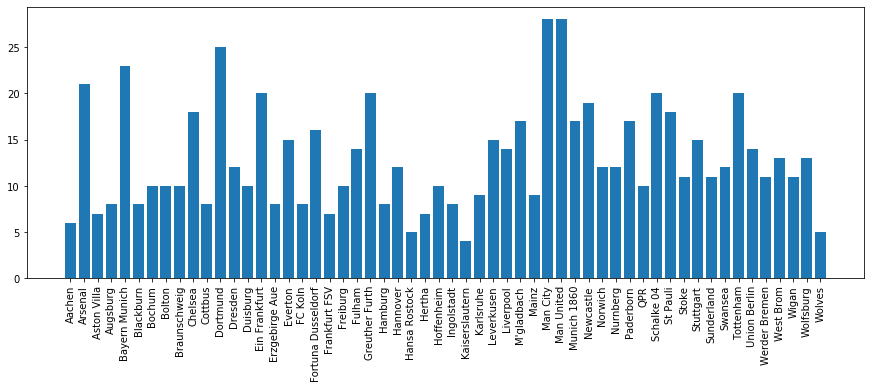

In [118]:
fig = plt.figure(figsize=(15, 5))

p1 = plt.bar(team_stats_2011.index, height=team_stats_2011.wins)
# p2 = plt.bar(team_stats_2011.index, height=team_stats_2011.losses)
plt.xticks(team_stats_2011.index, rotation='vertical')